In [3]:
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')

# Lecture: Personal networks of Berkeley students

### Load the survey responses

In [4]:
url = "../data/ucb_fa2021_personal_networks_clean.csv"

survey = Table.read_table(url)

Print the first few rows of the dataset to get a sense for how it is structured.

In [5]:
# show the first few rows of the dataset
survey.show(6)

interview_number,interview_date,interview_time,respondent_gender,respondent_age,respondent_class,respondent_home,number_alters,alter1_gender,alter1_age,alter1_class,alter1_home,alter1_howclose,alter1_howoften,alter2_gender,alter2_age,alter2_class,alter2_home,alter2_howclose,alter2_howoften,alter3_gender,alter3_age,alter3_class,alter3_home,alter3_howclose,alter3_howoften,alter4_gender,alter4_age,alter4_class,alter4_home,alter4_howclose,alter4_howoften,alter5_gender,alter5_age,alter5_class,alter5_home,alter5_howclose,alter5_howoften
1,2021-08-31,09:00:00,Male,21,Senior,Rest of World,5,Male,20,Senior,Rest of World,Close friend,More than once a week,Male,22,Senior,Rest of World,Close friend,More than once a week,Female,23,Junior,Rest of World,Close friend,More than once a week,Male,20,Senior,Rest of World,Friend,More than once a week,Male,20,Junior,Rest of World,Close friend,More than once a week
2,nan,10:00:00,Other,20,Senior,Rest of United States,5,Female,52,Other,Rest of United States,Close friend,More than once a week,Other,20,Senior,LA Area,Close friend,More than once a week,Male,53,Other,Rest of United States,Close friend,More than once a week,Male,17,Freshman,Rest of United States,Close friend,More than once a week,Male,17,Freshman,Rest of United States,Close friend,More than once a week
1,2021-08-31,09:04:00,Female,21,Junior,Rest of World,5,Female,57,Other,Rest of World,Close friend,Once a year,Male,57,Other,Rest of World,Close friend,Once a year,Female,23,Other,Rest of World,Friend,Once a month,Female,22,Senior,Rest of World,Friend,Once a week,Female,23,Senior,Rest of World,Friend,Once a year
1,2021-08-31,09:02:00,Female,20,Senior,Bay Area,5,Female,18,Freshman,Bay Area,Close friend,More than once a week,Female,21,Senior,Rest of California,Close friend,More than once a week,Female,21,Senior,Rest of United States,Close friend,More than once a week,Female,21,Senior,Rest of California,Close friend,More than once a week,Male,20,Senior,Rest of World,Close friend,Once a week
2,2021-08-31,10:18:00,Female,21,Senior,LA Area,5,Female,21,Senior,Rest of United States,Close friend,More than once a week,Female,58,Other,Rest of World,Close friend,More than once a week,Male,61,Other,Rest of World,Close friend,More than once a week,Female,21,Senior,Rest of United States,Close friend,More than once a week,Female,21,Senior,Rest of United States,Close friend,More than once a week
2,2021-08-31,09:40:00,Female,20,Junior,Bay Area,3,Female,20,Junior,Rest of United States,Close friend,More than once a week,Female,20,Junior,Bay Area,Close friend,More than once a week,Female,19,Senior,Rest of California,Close friend,More than once a week,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


How many responses are there?

In [6]:
num_responses = survey.num_rows
num_responses

209

### Who responded to the survey?

#### Respondent age

**Question** What do you expect will be the age range of people who responded to the survey? Why?

[ANS: It seems likely that people will have interviewed others who are similar to them. So we'd expect the age range of survey respondents to be similar to the age range of people in the class]

Now let's look at the data:

Highest and lowest ages of survey respondents:

In [7]:
# highest age
survey.column('respondent_age').max() # SOLUTION NO PROMPT

38

In [8]:
# lowest age
survey.column('respondent_age').min()

17

Average age of survey respondents:

In [9]:
np.mean(survey.column('respondent_age'))

20.79904306220096

Visualize the age distribution of respondents using a histogram:

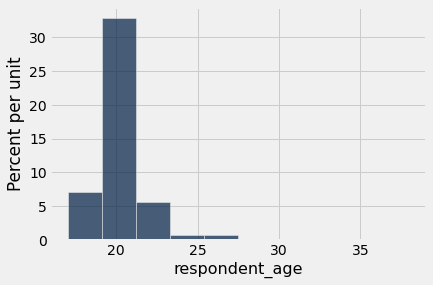

In [10]:
survey.select('respondent_age').hist()

#### Respondent gender

Look at the gender distribution

In [11]:
# make a table showing counts of respondents by gender
survey.group('respondent_gender')

respondent_gender,count
Female,108
Male,96
Other,5


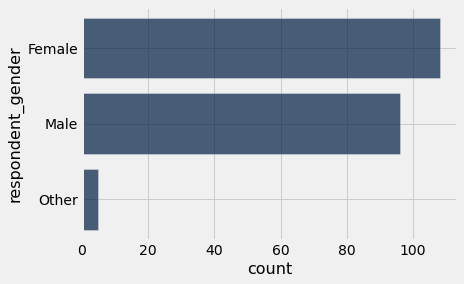

In [12]:
# make a horizontal bar plot showing the same information
survey.group('respondent_gender').barh('respondent_gender')

#### Respondent class year

Look at the class year

In [13]:
# make a table
survey.group('respondent_class')

respondent_class,count
Freshman,2
Junior,68
Other,10
Senior,112
Sophomore,17


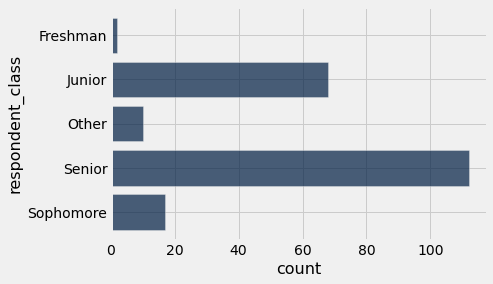

In [14]:
# make a horizontal bar plot
survey.group('respondent_class').barh('respondent_class')

Here's a different way to plot the same data, specifying the order of the bars.

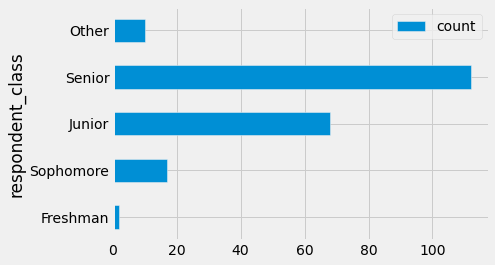

In [15]:
class_order = ['Freshman', 'Sophomore', 'Junior', 'Senior', 'Other']
survey.group('respondent_class').to_df().set_index('respondent_class').loc[class_order].plot.barh()

# Core discussion networks of Berkeley students

About how many confidents, on average, do Americans have?

[ANS: about 3]

Do you think that Berkeley students will have confidant networks that are the same size? Smaller? Larger?

[DISCUSS]

OK, let's see!

In [16]:
# distribution of number of reported confidants
survey.group('number_alters')

number_alters,count
1,3
2,4
3,15
4,17
5,130
6+,40


It can be easier to make sense of this kind of information with a plot:

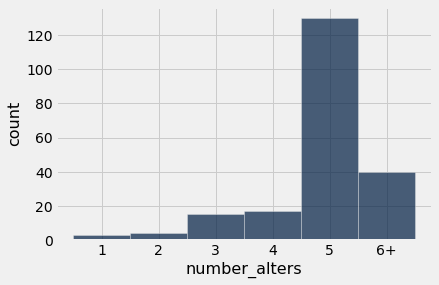

In [17]:
# bar plot showing the distribution of number of reported confidants
survey.group('number_alters').bar('number_alters')

It looks pretty clear that the average is higher than 3.

In [18]:
def recode_number_alters(na):
    if na in ['0', '1', '2', '3', '4', '5']:
        return int(na)
    elif na in ['6', '6+']:
        return 6

In [19]:
# apply the recode function to code 6+ alters to 6
survey['number_alters_recoded'] = survey.apply(recode_number_alters, 'number_alters') 

In [20]:
# make a table of the recoded values
survey.group('number_alters_recoded') 

number_alters_recoded,count
1,3
2,4
3,15
4,17
5,130
6,40


In [21]:
# calculate the average
np.mean(survey['number_alters_recoded'])

4.851674641148326

Note that this estimate is, if anything, low. Why?

[ANSWER: because we've recoded 6+ to 6, but some 6+ values could be even higher.]

We won't do this now, but an alternate approach would be to fit some kind of parametric distribution to the data we observe, and to use the inferred mean of that distribution as an estimate.  This would be an interesting extension to pursue.

### Is this a meaningful difference?

We see a difference in the point estimate between the average American discussion network and the network among Berkeley students. But, of course, this difference comes from a sample of Berkeley students. If we talked to a different set of Berkeley students, we could get a different answer. How do we know if what we observe in our sample is different enough from 3 to conclude that the networks of Berkeley students are in fact bigger?

We can actually estimate the sampling variation from the data we collected under the assumption that we have a random sample of Berkeley students. 

(This is a stretch, of course - we didn't actually take a random sample. What difference might we expect between the people in our dataset and a randomly selected set of Berkeley students?)

In order to estimate the sampling variation, we'll use an approach called resampling or the bootstrap.

We can take one resample of our survey like this:

In [22]:
resampled_survey = survey.select('number_alters_recoded').sample(num_responses)

To see what happened here, let's look at `resampled_survey`:

In [23]:
resampled_survey

number_alters_recoded
5
5
5
5
5
6
5
5
5
5


`resampled_survey` is a random sample of the data from the `number_alters_recoded` values recorded in the original survey dataset.

To estimate the sampling variation, we need many resamples. So we'll stick the resampling in a loop:

In [24]:
resampled_number_alters = make_array()

for _ in np.arange(10000):
    # NB: num_responses rows in our dataset
    resampled_survey = survey.select('number_alters_recoded').sample(num_responses)  # resample the survey
    resampled_number_alters = np.append(resampled_number_alters, 
                                        np.mean(resampled_survey['number_alters_recoded'])) # calculate the mean and add it to our list of means
resampled_net_size = Table().with_column('number_alters_recoded', resampled_number_alters)

`resampled_net_size` now has the average number of alters calculated for many different resamples of our data.

Let's look at the distribution of resampled network sizes

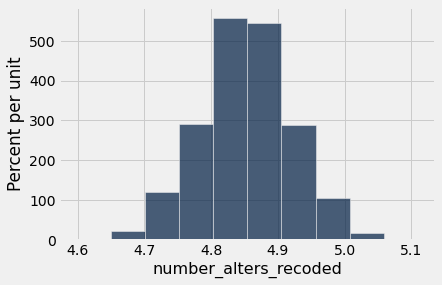

In [25]:
resampled_net_size.hist('number_alters_recoded')

We see that we do indeed get different estimates from sample to sample, but they are all bigger than 3. So this analysis suggests that it's safe to conclude that Berkeley students' discussion networks are bigger than the average American's discussion networks. This conclusion is based on our assumptions that (1) that we have a random sample of Berkeley students; and (2) that the average American's discussion network has 3 people in it.

# Respondents' confidants

Now let's dig a little deeper into who was names as a confidant by our survey respondents.

## Relationship between respondent and first alter named: gender

In Lab, you'll learn how to work with all of the alters that were named. Here in lecture, we'll keep things simple by looking at the relationship between the respondent and the first alter that the respondent named.

We'll start by looking at the alter's gender.

What is the distribution of genders among the first alters named?

In [26]:
# table of genders of the first alter named
survey.group('alter1_gender')

alter1_gender,count
Female,128
Male,75
Other,5
nan,1


Does the gender of the first named alter seem to be related to the gender of the ego?

In [27]:
# crosstab of respondent and alter1 gender
pd.crosstab(survey['respondent_gender'], survey['alter1_gender'], rownames=['ego'], colnames=['alter'])

alter,Female,Male,Other,nan
ego,,,,
Female,77,27,3,1
Male,49,47,0,0
Other,2,1,2,0


We might want to improve this table by looking at proportions by row. (NB: why by row?)

In [28]:
pd.crosstab(survey['respondent_gender'], survey['alter1_gender'], 
            rownames=['ego'], colnames=['alter'], normalize='index')

alter,Female,Male,Other,nan
ego,,,,
Female,0.712963,0.250000,0.027778,0.009259
Male,0.510417,0.489583,0.000000,0.000000
Other,0.400000,0.200000,0.400000,0.000000


How many egos name alters of a different gender? (We'll only deal with males and females to keep this simple.)

In [29]:
## calculate the fraction of all ties that involve pairs of different genders
obs_frac_nonhom = (27 + 49) / (77 + 27 + 49 + 47)
obs_frac_nonhom

0.38

### Is this a meaningful difference?

Again, we are faced with an important question: is the observed fraction of ego-alter pairs that is nonhomogenous by gender high? Low? What would we expect it to be?

To answer this question, we have to think about what we would expect to see if picking an alter were random

In [30]:
# narrow down to only male and female alters, to keep things simple
survey_altermf = survey.to_df()
survey_altermf = survey_altermf.loc[survey_altermf['alter1_gender'].isin(['Female', 'Male'])]
survey_altermf = Table().from_df(survey_altermf)
num_responses_mf = survey_altermf.num_rows
num_responses_mf

203

Let's shuffle our data to guarantee that the gender of the alter is random:

In [31]:
permuted_alter_gender = survey_altermf.select('alter1_gender').sample(num_responses_mf) # NB: num_responses rows in our dataset
permuted_dyads = Table().with_columns(
    'respondent_gender', survey_altermf.column('respondent_gender'),
    'alter1_gender', permuted_alter_gender.column(0))
permuted_dyads

respondent_gender,alter1_gender
Male,Female
Other,Male
Female,Female
Female,Female
Female,Female
Female,Male
Male,Male
Female,Male
Female,Female
Female,Male


We can summarize this relationship with a correlation coefficient

This reshuffled version of the data is the basis for a type of *null model* under which there is no relationship between ego's gender and alter's gender. This null model can be a useful comparison point for the observed data.

Let's write a function to help calculate the fraction of dyads that goes from male to female or from female to male.

In [32]:
def frac_mf_dyads(permuted_df):
    """
    Calculate the fraction of dyads that is male to female OR female to male
    """
    counts_mf = permuted_dyads.group(['respondent_gender', 'alter1_gender']).where('respondent_gender', 'Male').where('alter1_gender', 'Female')
    mf = counts_mf.column('count').item(0)
    counts_fm = permuted_dyads.group(['respondent_gender', 'alter1_gender']).where('respondent_gender', 'Female').where('alter1_gender', 'Male')
    fm = counts_fm.column('count').item(0)
    
    return((mf + fm)/permuted_df.num_rows)
    
#permuted_frac_mf = permuted_dyads.where()
frac_mf_dyads(permuted_dyads)

0.4729064039408867

Now take many resamples and calculate the fraction of cross-gender edges for each one

In [33]:
nonhom_fracs = make_array()

# NB: this loop follows a similar pattern to the loop we wrote above
for _ in np.arange(10000):
    permuted_alter_gender = survey_altermf.select('alter1_gender').sample(num_responses_mf) # NB: num_responses rows in our dataset
    permuted_dyads = Table().with_columns(
        'respondent_gender', survey_altermf.column('respondent_gender'),
        'alter1_gender', permuted_alter_gender.column(0))
    nonhom_fracs = np.append(nonhom_fracs, frac_mf_dyads(permuted_dyads))
null_fracs = Table().with_column('frac_dyads_nonhom', nonhom_fracs)

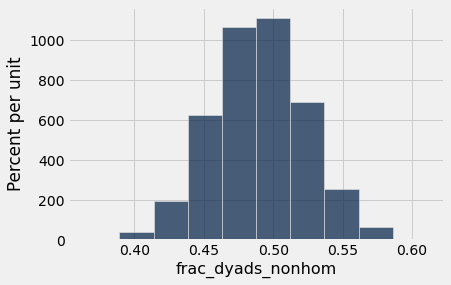

In [34]:
# make a histogram showing the resampled fraction of dyads that are nonhomogenous
null_fracs.hist('frac_dyads_nonhom')

Let's add a plot showing where our observed value is, so that we can easily compare the observed value to the null distribution.

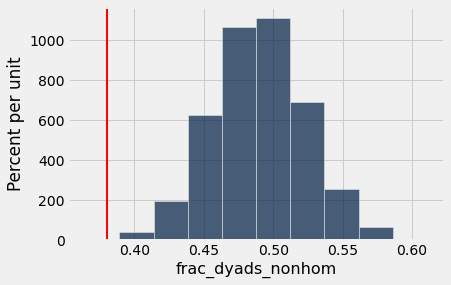

In [35]:
null_fracs.hist('frac_dyads_nonhom')
#plt.scatter(obs_frac_nonhom,0,c='red',s=80);
plt.axvline(x=obs_frac_nonhom,c='red',linewidth=2);

Let's compare the expected value (average) of the null model to this distribution

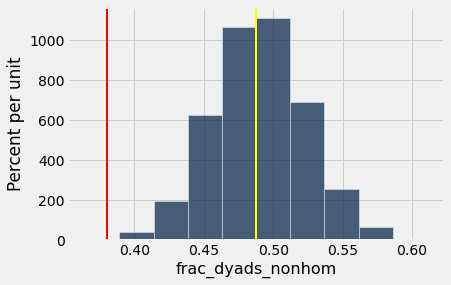

In [36]:
null_ev = np.mean(null_fracs['frac_dyads_nonhom'])
null_fracs.hist('frac_dyads_nonhom')
#plt.scatter(null_ev,0,c='yellow',s=80);
plt.axvline(x=null_ev,c='yellow',linewidth=2);
plt.axvline(x=obs_frac_nonhom,c='red',linewidth=2);

## Relationship between respondent and first alter named: age

We can summarize this relationship with a correlation coefficient

In [37]:
# calculate the correlation coefficient
survey.to_df()[['respondent_age', 'alter1_age']].corr()

,respondent_age,alter1_age
respondent_age,1.000000,0.128643
alter1_age,0.128643,1.000000


In [38]:
# alternate way to do this using numpy (shows how to handle removing nans)
mask = ~np.isnan(survey.column('respondent_age')) & ~np.isnan(survey.column('alter1_age'))
np.corrcoef(survey['respondent_age'][mask], survey['alter1_age'][mask])

array([[1.        , 0.12864339],
       [0.12864339, 1.        ]])

Making a visualization helps suggest why the correlation coefficient is (perhaps) lower than expected:

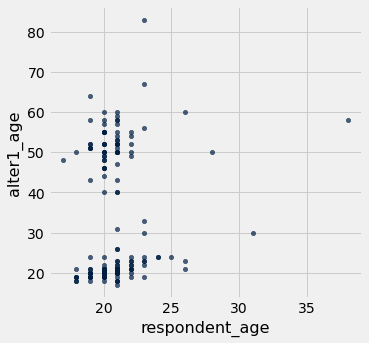

In [39]:
# plot alter1_age (y axis) vs respondent_age (x axis)
survey.scatter('respondent_age', 'alter1_age')

You'll take a deeper dive in lab.

## Relationship between respondent and first alter named: class year

In [40]:
# table showing counts of the class year of first alter named (cols) by class year of respondent (rows)
pd.crosstab(survey['respondent_class'], survey['alter1_class'], rownames=['ego'], colnames=['alter'])

alter,Freshman,Junior,Other,Senior,Sophomore
ego,,,,,
Freshman,1,0,0,1,0
Junior,0,32,31,3,2
Other,0,0,8,2,0
Senior,1,5,46,53,7
Sophomore,0,3,5,0,9


In [41]:
# normalize the table we just made by rows
pd.crosstab(survey['respondent_class'], survey['alter1_class'], rownames=['ego'], colnames=['alter'], 
            normalize='index')

alter,Freshman,Junior,Other,Senior,Sophomore
ego,,,,,
Freshman,0.500000,0.000000,0.000000,0.500000,0.000000
Junior,0.000000,0.470588,0.455882,0.044118,0.029412
Other,0.000000,0.000000,0.800000,0.200000,0.000000
Senior,0.008929,0.044643,0.410714,0.473214,0.062500
Sophomore,0.000000,0.176471,0.294118,0.000000,0.529412


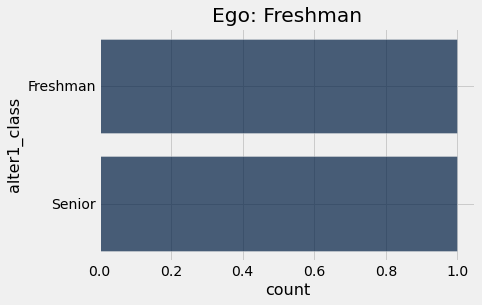

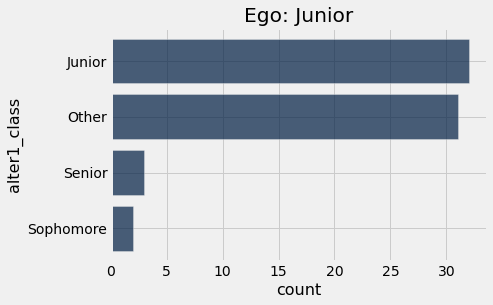

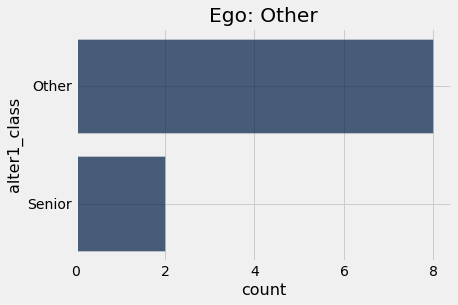

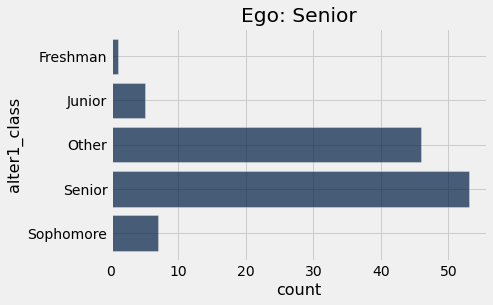

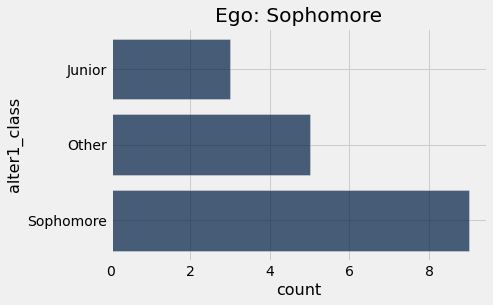

In [42]:
# make a plot showing the distribution of alter class for each ego class value
for g in np.unique(survey['respondent_class']):
    this_class_resp = survey.where('respondent_class', are.equal_to(g))
    this_class_resp.group('alter1_class').barh('alter1_class');
    plt.title('Ego: ' + g)

In [43]:
# end of demo